<p style="text-align:left; font-size:90%">
    BUSA90501 Machine Learning
    <span style="float:right;">© 2021 University of Melbourne (excluding links to external content)</span>
</p>

# Workshop 5: Uncertainty Estimation and Feature Expansion

In this workshop we will investigate regression models with a focus on analysing uncertainty estimates. We will also show an easy way to turn linear regression into a non-linear model by using feature expansion.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
np.random.seed(1)
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

# Mauna Loa dataset

The Mauna Loa dataset consists of the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppmv)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2001. It has one feature: year; and one target: CO2 concentration. The objective is to model the CO2 concentration as a function of the time t. 

In [10]:
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data.iloc[:, 0]
    m = ml_data.data.iloc[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()

Since we have only one feature, we can easily plot the data. This will allow us to inspect and understand any particular trends in the data.

Text(0.5, 1.0, 'Atmospheric CO$_2$ concentration at Mauna Loa')

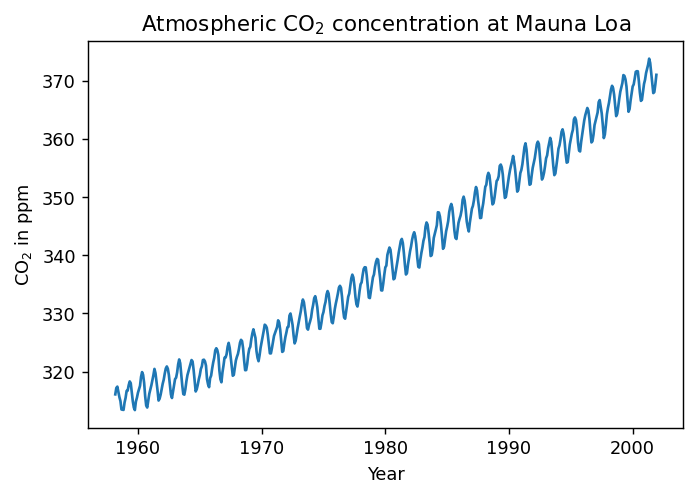

In [11]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
plt.figure()
#plt.scatter(X, y, marker='.',s=5)
plt.plot(X,y)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")

<blockquote style="padding: 10px; background-color: #ebf5fb;">

#### Question 1 (Discussion)
What is the relationship between Year and CO2? What kind of trend do you see? Is it plausible to use a linear model to fit the data?
</blockquote>
<details> 
    <summary> **Click me for answer** </summary>
<blockquote style="padding: 10px; background-color: #aaffaa;">

#### Answer
There are two trends: a linear one and a periodic one. A linear model will not be able to model the periodic trend so it is not the best choice here.
</blockquote>
</details>
 
Now, we need to split the dataset into training set and test set. Because Mauna Loa is a time series dataset, we need to follow the temporal nature of the data. This means we should use past data as training data and make predictions on future data. Thus, we split dataset into two time periods: 1960-1997 as training set, and 1998-2001 as test set.

In [390]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Ridge Regression

By adding an L2 norm regularisation term to linear regression, we obtain a Ridge regression model.
The original problem is to minimize:
\begin{align*}
\| \mathbf{y} - \mathbf{X}\mathbf{w} \|^2_2
\end{align*}

Ridge regression works by minimising the following objective:

\begin{align*}
\| \mathbf{y} - \mathbf{X}\mathbf{w} \|^2_2 + \alpha \| \mathbf{w} \|^2_2
\end{align*}
for $\alpha >0 $ ($\lambda$ in the lecture)

While we can use gradient descent to obtain a solution, in the case of Ridge, the solution can be obtained in closed form by using the set of normal equations.
\begin{align*}
\mathbf{w} = (\mathbf{X}^\top \mathbf{X} + \alpha \mathbb{1})^{-1} \mathbf{X}^\top \mathbf{Xy}
\end{align*}

Let's start by training and evaluating a Ridge regression model on our split of the Mauna Loa dataset. Notice we also normalize the data: this is done to help training the model (not so important in Ridge but important in the BayesianRidge model we will see later). We also start with a small alpha initially.


In [391]:
from sklearn.linear_model import Ridge
clf = Ridge(normalize=True, alpha=0.001)
clf.fit(x_train, y_train)
print("MSE on training set %.3f"
     % np.mean((y_train - clf.predict(x_train))**2))
print("MSE on test set %.3f"
     % np.mean((y_test - clf.predict(x_test))**2))

MSE on training set 6.934
MSE on test set 16.542


As expected, the MSE (mean squared error) on the test set is higher than the training set. However, this does not tell us much about the behaviour of the model. Let's plot the dataset again, but add the resulting model as well (which is a straight line).

As a warm-up, let's also plot the uncertainty around the line: for every data point, we plot a 0.95 Credible Interval (CI) around it, which is approximately equivalent to the standard deviation multiplied by 2. In the case of Ridge, we can obtain the standard deviation through the Sum of Squared Errors, as the std is just the square root of the variance.

In [392]:
sse = np.sum((y_train - clf.predict(x_train))**2)
model_var = sse / len(y_train)
model_std = np.sqrt(model_var)
model_std

2.633206682391309

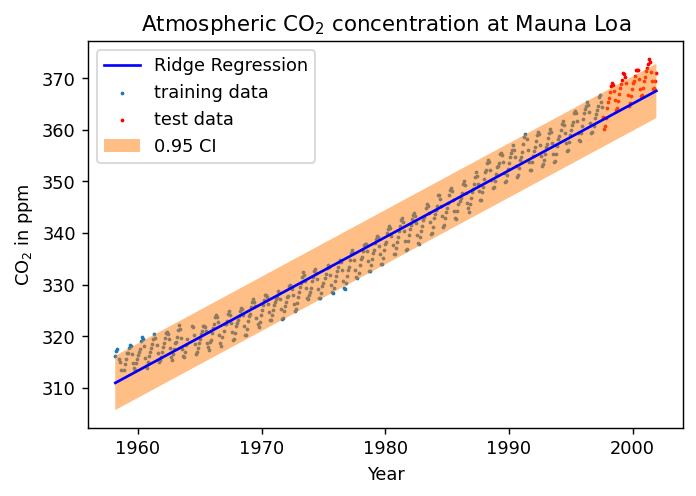

In [393]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
plt.figure()
plt.scatter(x_train, y_train, marker='.',label='training data',s=5)
plt.scatter(x_test, y_test, marker='.',color = 'red',label='test data',s=5)
plt.plot(X.reshape(-1,1), clf.predict(X), 'b-',label = 'Ridge Regression')
plt.fill_between(X[:, 0], clf.predict(X) - (model_std*2), clf.predict(X) + (model_std*2),
                 alpha=0.5,label='0.95 CI')
plt.legend()
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.show()

As you saw in the lecture, the MLE variance estimate is constant for all data points, which results in a fixed width CI around the line. As it is, it is not very informative for predictions. However, we can still see an interesting pattern here: most data points are located inside the interval.

Intuitively, the model is "telling" us that it managed to detect the linear trend in Mauna Loa, but it is "aware" of variations inside that trend. We know there is an periodic trend but this is not within the capacity of a linear model such as Ridge. Therefore, it "decides" to explain this unknown trend as just "noise".

<blockquote style="padding: 10px; background-color: #ebf5fb;">

#### Question 2 
Try training the Ridge model again, but set the "alpha" parameter to 1. Plot the resulting line with the data, including the CIs. What changed? Can you explain this new behaviour? Hint: remember that "alpha" in scikit-learn is the same as "lambda" in the lecture slides; what is the relation between "alpha" and the model variance?
</blockquote>

<details> 
    <summary> **Click me for answer** </summary>
<blockquote style="padding: 10px; background-color: #aaffaa;">

#### Answer
The model will underfit, resulting in a much larger CI. The relationship is "alpha = sigma/tau", where sigma is the data variance and tau is the weight variance. Increasing alpha means we are decreasing tau. This result in a weight prior distribution that is peaked around the zero mean. In other words, it "forces" the weights to be smaller (around zero), which is exactly what happens when we increase the regularisation coefficient. Since the resulting line is now closer to a constant line, the CIs get larger in order to accommodate the data.
</blockquote>
</details>

Still, the fixed width interval is a pretty crude estimate of uncertainty. Let's try a Bayesian Linear Regression model and see if we can get something more informative.

# Bayesian Linear Regression

We now follow the same procedure but with Bayesian Linear Regression.

In [384]:
from sklearn.linear_model import BayesianRidge
bayes_clf = BayesianRidge(normalize=True)
mean_y = np.mean(y_train)
bayes_clf.fit(x_train, y_train)
pred_y_train, pred_y_train_std = bayes_clf.predict(x_train, return_std=True)
pred_y_test, pred_y_test_std = bayes_clf.predict(x_test, return_std=True)
print("MSE on training set %.3f"
     % np.mean((y_train - (pred_y_train))**2))
print("MSE on test set %.3f"
     % np.mean((y_test - pred_y_test)**2))


MSE on training set 6.934
MSE on test set 16.365


The MSE did not change compared to Ridge. This is expected.

<blockquote style="padding: 10px; background-color: #ebf5fb;">

#### Question 3
Can you explain why the model got the same performance?
</blockquote>

<details> 
    <summary> **Click me for answer** </summary>
<blockquote style="padding: 10px; background-color: #aaffaa;">

#### Answer
The MSE performance metric only takes the mean of the predictive distribution into account. In Bayesian Linear Regression this is the same as in standard Ridge, therefore MSE is not affected. It is the variance of the predictive distribution that changes.
</blockquote>
</details>

Let's check the CIs

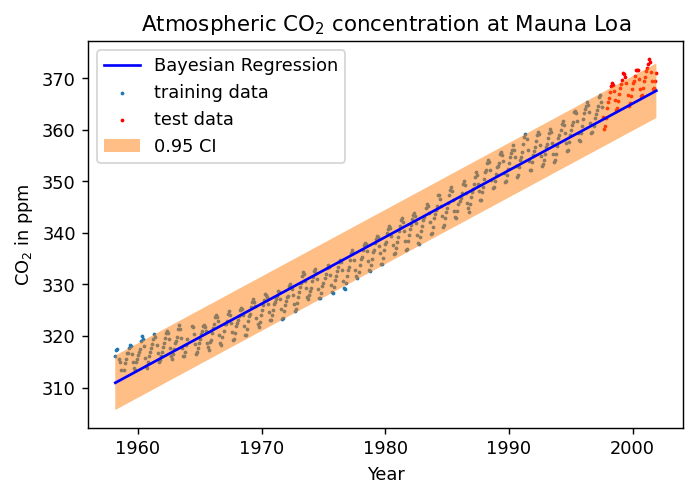

In [385]:
pred_y, pred_y_std = bayes_clf.predict(X, return_std=True)

FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
plt.figure()
plt.scatter(x_train, y_train, marker='.',label='training data',s=5)
plt.scatter(x_test, y_test, marker='.',color = 'red',label='test data',s=5)
plt.plot(X.reshape(-1,1), pred_y, 'b-',label = 'Bayesian Regression')
plt.fill_between(X[:, 0], pred_y - (pred_y_std*2), pred_y + (pred_y_std*2),
                 alpha=0.5,label='0.95 CI')
plt.legend()
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.show()

At first, it does not look like much changed. Let's inspect the predicted standard deviations.

In [341]:
print(pred_y_test_std)

[2.64440174 2.64447343 2.64454543 2.64461772 2.64469032 2.64476322
 2.64483643 2.64490993 2.64498374 2.64505785 2.64513227 2.64520698
 2.645282   2.64535732 2.64543294 2.64550887 2.6455851  2.64566162
 2.64573846 2.64581559 2.64589302 2.64597076 2.6460488  2.64612714
 2.64620579 2.64628473 2.64636398 2.64644353 2.64652338 2.64660353
 2.64668398 2.64676474 2.6468458  2.64692716 2.64700882 2.64709078
 2.64717305 2.64725561 2.64733848 2.64742165 2.64750512 2.64758889
 2.64767297 2.64775734 2.64784202 2.64792699 2.64801227 2.64809785
 2.64818374 2.64826992 2.6483564  2.64844319 2.64853028]


These values are very close to the fixed, estimated variance of Ridge. However, they do slightly change. In particular, it looks like it increases over time. Let's try to predict far into the future.

In [342]:
print(bayes_clf.predict([[2100]], return_std=True))
print(bayes_clf.predict([[2200]], return_std=True))
print(bayes_clf.predict([[2300]], return_std=True))

(array([494.59525327]), array([2.9451684]))
(array([624.08864614]), array([3.55842465]))
(array([753.58203902]), array([4.35541244]))


We can see larger differences in the standard deviation. This is the desired behaviour: the further we try to extrapolate, the larger is our uncertainty.

While it is nice to have this behaviour, the current model is still quite impractical if we want to estimate uncertainty in the short term. This is because, as in standard Ridge, most of the uncertainty is due to the lack of capacity of the model to fit the periodical trend, treating it as "noise".

Ideally, we need to fit a non-linear model. In this case, we can try a simple technique called feature expansion, in order to try to capture the periodic trend.

# Feature Expansion

This is a simple technique to enhance linear models when we have non-linear data. Using the Mauna Loa data as an example, we will move from a one-dimensional scalar input $x$ to a vector $[e_1(x),e_2(x),...,e_n(x)]$. Here, each $e$ is a function of $x$.

There are many ways to perform this step. In our case, since our data is one-dimensional we were able to plot it and inspect for trends. We can use this to inform the expansions:
- First, a linear trend is definitely present in the data. Therefore, let's define the first expansion as just the identity: $e_1(x) = x$
- Second, while the linear trend is a good approximation, the slope changes slightly, in particular between 1970-1990. The CIs plotted above clearly show this. An easy way to let the model capture this "curve" is to add a quadratic feature: $e_2(x) = x^2$
- Third, we can use trigonometry to model the periodic trend. A simple way would be to use the sine function: $e_3(x) = sin(x)$. However, this will not work: we need to multiply it by $2\pi$. Therefore, we have $e_3(x) = sin(2\pi x)$

<blockquote style="padding: 10px; background-color: #ebf5fb;">

#### Question 4 (optional)
Why do we need to multiply $x$ by $2\pi$ when using the sine function?
</blockquote>


<details> 
    <summary> **Click me for answer** </summary>
<blockquote style="padding: 10px; background-color: #aaffaa;">

#### Answer
Multiplying by $2\pi$ forces the expansion to follow a *cycle* or *period*. Intuitively, we want to assume that the periodic trend within a year is the same, regardless of the year. For example, we want the value for January 1970 and January 1989 to be the same. The Mauna Loa data uses round numbers (1970, 1989) as the January reading, with following months using fractional numbers (1970.083, 1970.166, 1970.25, ...). If we dont multiply by $2\pi$ we will have $sin(1970) \ne sin(1989)$, which is not what we want. On the other hand, $sin(1970 \times 2\pi) = sin(1989 \times 2\pi)$.    
    Bear in mind other datasets might need adjustments to the expansion depending on what kind of periodic trend they show (for example, every 3 months instead of every year).
</blockquote>
</details>

In [376]:
def expand(x):
    return np.concatenate((x, x**2, np.sin((x*2*np.pi))),axis=1)


bayes_clf = BayesianRidge(normalize=True)

expand_x_train = expand(x_train)
expand_x_test = expand(x_test)

bayes_clf.fit(expand_x_train, y_train)
pred_y_train, pred_y_train_std = bayes_clf.predict(expand_x_train, return_std=True)
pred_y_test, pred_y_test_std = bayes_clf.predict(expand_x_test, return_std=True)
print("MSE on training set %.3f"
     % np.mean((y_train - (pred_y_train))**2))
print("MSE on test set %.3f"
     % np.mean((y_test - pred_y_test)**2))

MSE on training set 0.877
MSE on test set 1.700


That's an impressive improvement! Let's plot the data with the CIs.

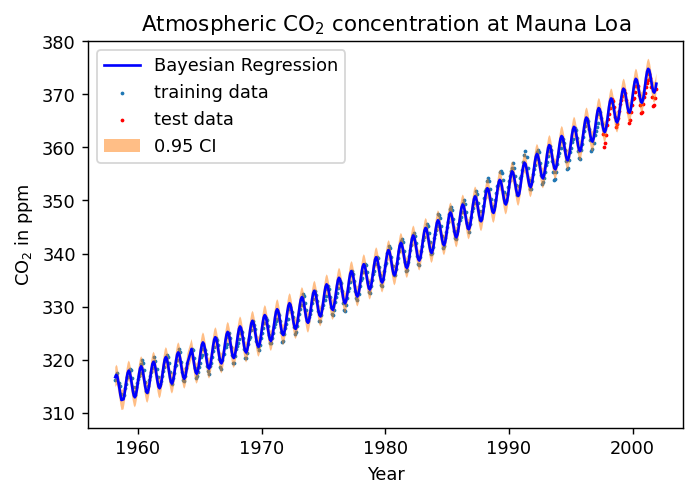

In [377]:
expand_X = expand(X)
pred_y, pred_y_std = bayes_clf.predict(expand_X, return_std=True)

FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
plt.figure()
plt.scatter(x_train, y_train, marker='.',label='training data',s=5)
plt.scatter(x_test, y_test, marker='.',color = 'red',label='test data',s=5)
plt.plot(X.reshape(-1,1), pred_y, 'b-',label = 'Bayesian Regression')


plt.fill_between(X[:, 0], pred_y - (pred_y_std*2), pred_y + (pred_y_std*2),
                 alpha=0.5,label='0.95 CI')
plt.legend()
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.show()

We can see that with a better fit, the CIs also shrink around the mean. Let's inspect them in more detail.

In [345]:
print(pred_y_test_std)
print(bayes_clf.predict(expand(np.array([[2100]])), return_std=True))
print(bayes_clf.predict(expand(np.array([[2200]])), return_std=True))
print(bayes_clf.predict(expand(np.array([[2300]])), return_std=True))

[0.94825358 0.94947379 0.95015401 0.94978935 0.94888267 0.94844831
 0.9490114  0.95009948 0.95073707 0.95043634 0.94968867 0.94947057
 0.95025277 0.95150744 0.95221813 0.95188022 0.95099631 0.95058074
 0.95116054 0.95226745 0.95293058 0.95266416 0.95195771 0.95178316
 0.9526068  0.95389877 0.95464275 0.95433455 0.95347636 0.95308225
 0.95368108 0.95480908 0.95550038 0.9552715  0.95460992 0.95448247
 0.95535073 0.95668286 0.957463   0.95718758 0.95635821 0.95598835
 0.95660861 0.95776001 0.95848217 0.95829417 0.95768117 0.95760446
 0.95852053 0.95989571 0.96071494 0.96047544 0.9596781 ]
(array([686.34160845]), array([5.66112477]))
(array([1262.788553]), array([18.56525297]))
(array([2099.0682593]), array([39.04291803]))


In general, the variance tends to increase with time but now we see a few fluctuations due to the periodic nature. More important, the long-term forecasts are quite different from the linear model.

<blockquote style="padding: 10px; background-color: #ebf5fb;">

#### Question 5 
Can you explain this difference?
</blockquote>

<details> 
    <summary> **Click me for answer** </summary>
<blockquote style="padding: 10px; background-color: #aaffaa;">

#### Answer
It's very likely due to the addition of the quadratic term. We can inspect the coefficients of the expanded model to check that.
</blockquote>
</details>

# Random Forest Regressor

Now, as an alternative non-linear model, let's try to fit a random forest regressor.

In [346]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

rfreg = RandomForestRegressor()
rfreg.fit(x_train, y_train)
print("MSE on training set %.3f"
     % np.mean((y_train - rfreg.predict(x_train))**2))
print("MSE on test set %.3f"
     % np.mean((y_test - rfreg.predict(x_test))**2))

MSE on training set 0.084
MSE on test set 19.770


Low training error but high test error... Do you know what that means?

Let's try to get Confidence Intervals (remember, these are not the same as Credible Intervals used in Linear Regression). There is not a simple method to return the std for a scikit-learn RandomForest. To do this, we can access individual trees inside the RandomForest object.

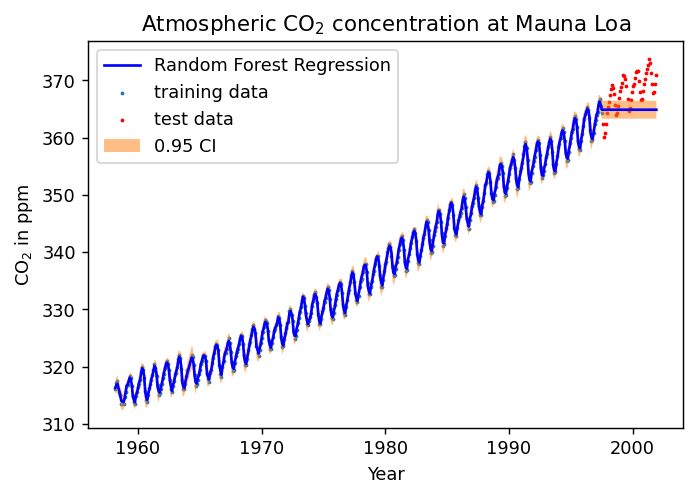

In [347]:
def predict_rf(x, rf):
    preds = []
    for tree in rf.estimators_:
        preds.append(tree.predict(x))
    preds = np.array(preds)
    return np.mean(preds, axis=0), np.std(preds, axis=0)

means, stds = predict_rf(X, rfreg)

FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
plt.figure()
plt.scatter(x_train, y_train, marker='.',label='training data',s=5)
plt.scatter(x_test, y_test, marker='.',color = 'red',label='test data',s=5)
plt.plot(X.reshape(-1,1), means, 'b-',label = 'Random Forest Regression')
plt.fill_between(X[:, 0], means - (stds*2), means + (stds*2),
                 alpha=0.5,label='0.95 CI')
plt.legend()
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.show()

That's pretty terrible...


<blockquote style="padding: 10px; background-color: #ebf5fb;">

#### Question 6
Random Forest can perfectly fit the training data, but it lost the ability to make good predictions in test set. Can you tell why did this happen?
</blockquote>
<details> 
    <summary> **Click me for answer** </summary>
<blockquote style="padding: 10px; background-color: #aaffaa;">

#### Answer
To understand this, first remember that a Random Forest is just a collection of Decision Trees, each trained on a bootstrapped training set. When performing regression, a Decision Tree populates its leaves with *constant* values (usually the mean of the datapoints present in the leaf). In the case of Mauna Loa, each split is based on the input year. But the test data only contains years that came *after* the most recent year in the training set. This means that all years that come after this most recent year will end up in the same leaf at test time, which has a constant value. Since this happens for all years in the test set and for all trees in the forest, the result is a constant prediction (with constant confidence intervals).
    More generally, this shows an important *drawback* of Decision Trees and Random Forests: they are unable to *extrapolate* numerical data. A few extensions were proposed to tackle this drawback. For instance M5P (sci2s.ugr.es/keel/pdf/algorithm/congreso/1992-Quinlan-AI.pdf) trees equip leaves with their own linear regression models. Such models are much less used in practice though (for instance, scikit-learn does not have a M5P implementation).
</blockquote>
</details>

# Suggestions for extra tasks

This is the end of the workshop. If you want to play with the data and the models a bit more here are a few suggestions:

- Try fitting an ensemble of Multilayer Perceptrons to Mauna Loa. Use bagging to obtain confidence intervals, as in the Random Forest example. Does it perform better?
- Change the training/test temporal split to a random one. This is now simulating *interpolation* instead of extrapolation. Check the models performance in this setting.
- Calculate the predictive likelihood for a few test set predictions, using both Bayesian Regression and Random Forests. Remember that in Linear Regression the predictive distributions are Gaussians, while for RFs we can *assume* the mean and std of the ensemble follows a Gaussian.
- Calculate the Pinball Loss for a few test set predictions, using different costs for over and underestimates. Try the "far-future" years predictions in particular.


---
# EXTRA: Treating the problem as function approximation using gradient descent with backpropagation

Looking at the graph of the time series, the first thing I thought of doing is to fit it to a linear function but modulated with a sine function that is obviously having period matching the seasons
$$
f(x) = a_0 + a_1 x + b_0 sin(b_1 x)
$$
where $a_0, a_1$ can be obtained by linear regresion (or just approximate the intercept and slope from data), $b_1 = 2 \pi$ meaning the period is a year and $b_0$ is the approximate amplitude of the sine wave. 

We do just that below. (note that the initial coefficient for the $x^2$ and $x^3$ terms are 0, so we do have linear + sine initially). 

In [410]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False)

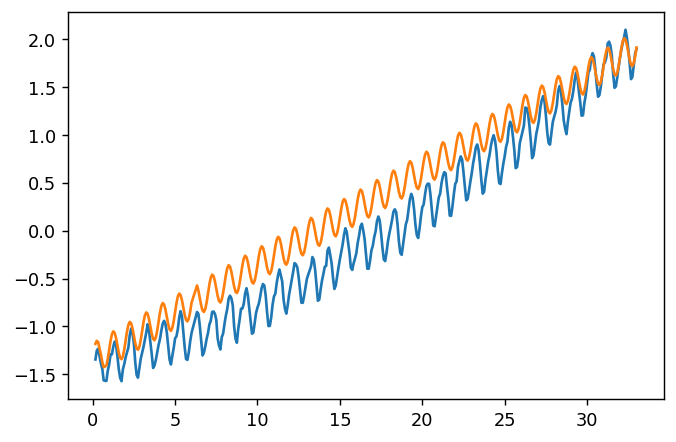

In [432]:
import torch

# note: I normalise the data here, otherwise things becomes unstable when we consider the x^2 and x^3 terms
data = torch.tensor(x_train.reshape(-1) - 1958)
mu = np.mean(y_train)
sigma = np.std(y_train)
outputs = torch.tensor((y_train - mu) / sigma)

# initial estimates of the parameters
params = [
    torch.tensor(outputs[0].item(), requires_grad=True), 
    torch.tensor(((outputs[-1] - outputs[0]) / (data[-1] - data[0])).item(), requires_grad=True), 
    torch.tensor(0.0, requires_grad=True), 
    torch.tensor(0.0, requires_grad=True), 
    torch.tensor(0.17, requires_grad=True), 
    torch.tensor(2 * np.pi, requires_grad=True),
]

def f(data):
    return (
        params[0] 
        + params[1] * data 
        + params[2] * data**2
        + params[3] * data**3
        + params[4] * torch.sin(params[5] * data)
    )

with torch.no_grad():
    plt.plot(data, outputs, '-')
    plt.plot(data, f(data))

And ... we got a reasonable fit. But to find the best parameters, we can either use the optimisers built in for the Bayesian regression above, or we can practice coding up gradient descent.

**One lesson below if you try to do gradient descent is that it is quite hard to get right** 
 * Vary the learning rate, number of epoch and see their effect.
 * If the data is not normalised, we will have issue with huge numbers. 
 * Try using different optimisers..

In [433]:
# gradient descent
pred = f(data)
loss = torch.nn.functional.mse_loss(pred, outputs)
optimiser = torch.optim.Adam(params, lr=0.001)

num_epoch = 10000
lf = num_epoch / 10
for epoch in range(num_epoch):
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
    # logging 
    pred = f(data)
    loss = torch.nn.functional.mse_loss(pred, outputs)
    if epoch % lf == 0:
        print(f"Epoch: {epoch}, loss = {loss.item()}")

print("Optimised paramters: \n", [x.item() for x in params])
print("Residue gradients  : \n", [x.grad.item() for x in params])

Epoch: 0, loss = 199.28721730634533
Epoch: 1000, loss = 0.009942356060289639
Epoch: 2000, loss = 0.004902593987663719
Epoch: 3000, loss = 0.003976310453030673
Epoch: 4000, loss = 0.0038090563292294526
Epoch: 5000, loss = 0.003743268772706136
Epoch: 6000, loss = 0.0036704256166439305
Epoch: 7000, loss = 0.017981797485561744
Epoch: 8000, loss = 0.003574782666755829
Epoch: 9000, loss = 0.0038095722427180546
Optimised paramters: 
 [-1.469818353652954, 0.05857795104384422, 0.0011340708006173372, 7.625686066603521e-06, 0.22584977746009827, 6.277369976043701]
Residue gradients  : 
 [-0.0022500541526824236, 0.016100581735372543, -0.030577264726161957, -0.024811409413814545, 6.856156460344209e-07, 2.9287707548064645e-06]


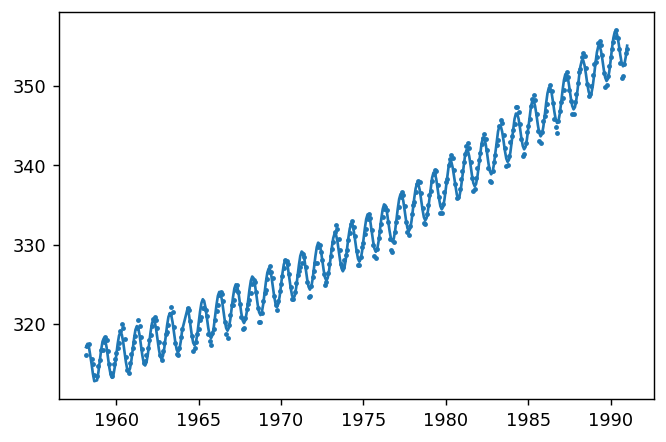

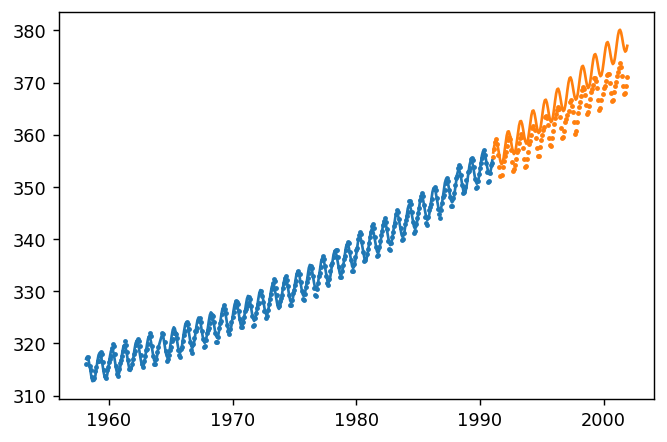

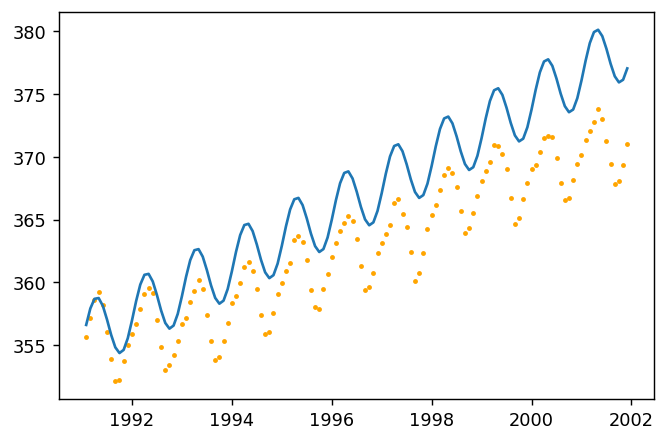

In [434]:
plt.scatter(data + 1958, outputs *  sigma + mu, s=3)
plt.plot(data + 1958, f(data).detach() * sigma + mu)

plt.figure()
plt.scatter(data + 1958, outputs *  sigma + mu, s=3)
plt.plot(data + 1958, f(data).detach() * sigma + mu)

z = torch.tensor(x_test.reshape(-1) - 1958)
z_out = torch.tensor((y_test - mu) / sigma)
#plt.plot(z, z_out)
plt.scatter(x_test, y_test, s=3)
plt.plot(z + 1958, f(z).detach() * sigma + mu)


plt.figure()
plt.scatter(x_test, y_test, s=3, color="orange")
plt.plot(z + 1958, f(z).detach() * sigma + mu)


### Long term behaviour of the model
Becareful that we might get a negative coefficients for the cubic term which means that long-term the prediction might go negative....

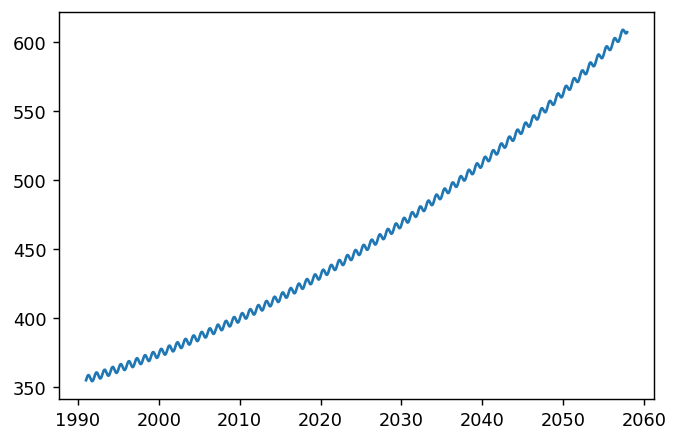

In [435]:
w = torch.arange(33, 100, 1/12)
plt.plot(w + 1958, f(w).detach() * sigma + mu)
